# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no, changed in October by André Brodtkorb

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

import IPythonMagic

In [3]:
%setup_logging
%cuda_context_handler context

Python version 3.6.6 (default, Sep 12 2018, 18:26:19) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
Registering context in user workspace
Context already registered! Ignoring


In [5]:
cuda_kernel = """
__global__ void matrixVectorKernel(float* c, float* A, float* b, int a_rows, int a_cols) {
    unsigned int j = blockIdx.x*blockDim.x + threadIdx.x;
    
    //Out of bounds check
    if (j > a_rows) {
        return;
    }
    
    //Compute inner product of row of A with column of B
    float sum = 0.0f;
    for (int i=0; i<a_cols; ++i) {
        unsigned int k = j*a_cols + i;
        sum += A[k] * b[i];
    }
    
    //Write to global memory
    c[j] = sum;
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("matrixVectorKernel");

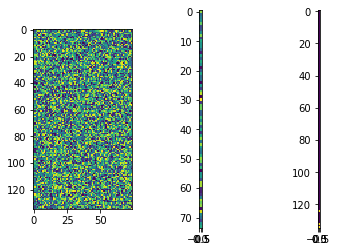

In [14]:
#Size of our test
test_size = (135, 74)

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.random((test_size[1], 1)).astype(np.float32)
c = np.empty((test_size[0], 1), dtype=np.float32)

fig = plt.figure()
plt.subplot(1,3,1)
plt.imshow(a)
plt.subplot(1,3,2)
plt.imshow(b)
plt.subplot(1,3,3)
plt.imshow(c)
fig.show()

In [15]:
#Upload data to the device
#NOTE: We need to make sure that a=(a_rows, a_columns)
# and that b=(a_colmuns, 1) (column vector)
# and that c=(a_rows, 1)
a_g = GPUArray(a.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
a_g.set(a)
b_g.set(b)

In [16]:
#Allocate output data
c_g = GPUArray(c.shape, np.float32)

In [17]:
#NOTE: We need to change this so that the grid*block is x = 1, y = number of rows in A
block_size = (128, 1, 1) #These need to be [x, y, z]
grid_size = (int(np.ceil(c.shape[0] / 128)), 1, 1)

print("Block size is " + str(block_size))
print("Grid size is " + str(grid_size))

Block size is (128, 1, 1)
Grid size is (2, 1, 1)


In [26]:
#Execute program on device
kernel(c_g, a_g, b_g, np.int32(a.shape[0]), np.int32(a.shape[1]), block=block_size, grid=grid_size)

#Copy data from device to host
c_g.get(c)
pass #To skip printing of c

In [23]:
#Compute reference using Numpy
c_ref = np.dot(a, b)

#Sum of absolute differences
sad = np.sum(np.abs(c - c_ref))

#Print result
# print("C   = ", c)
# print("Ref = ", c_ref)
print("Sad = ", sad)
print("Per element error: " + str(sad / test_size[1]))

Sad =  0.00023651123
Per element error: 3.196097709037162e-06


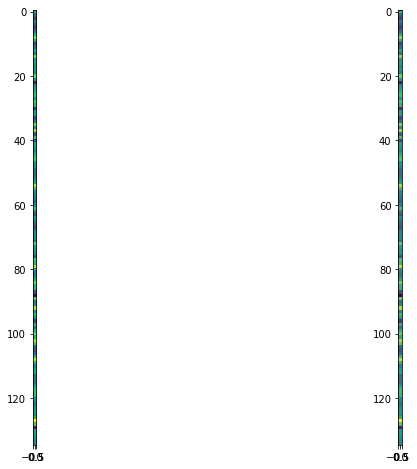

In [20]:
fig = plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(c)
plt.subplot(1,2,2)
plt.imshow(c_ref)